<a href="https://colab.research.google.com/github/kunakl07/Killer-Whale-sound-classification/blob/master/Preprocessing_basic_Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install pydub
from pydub import AudioSegment
import numpy as np

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from scipy.io import wavfile
import wave
import glob
import csv
import pylab
import librosa
import librosa.display
import numpy as np
import scipy
from skimage.restoration import (denoise_wavelet, estimate_sigma)

%matplotlib inline
matplotlib.style.use('ggplot')
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

plt.rcParams.update({'figure.max_open_warning': 0})

In [0]:
!ls

sample_data	  sel.02.Grunt.wav  sel.05.Grunt.wav
sel.01.Grunt.wav  sel.03.Grunt.wav


In [0]:
fname = '/content/S_1.wav'
data, sr =librosa.core.load(fname, sr=44100, res_type='kaiser_fast')
print("Sampling (frame) rate = ", sr)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (227811,)
[-0.00579834 -0.00448608 -0.00457764 ... -0.00476074 -0.00198364
  0.00033569]


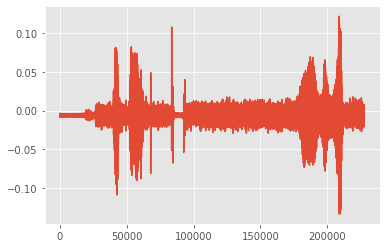

In [0]:
plt.plot(data, '-', );

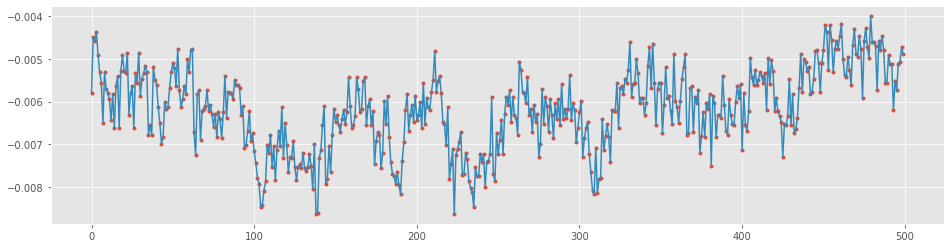

In [0]:
# Looking at first 500 frames

plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

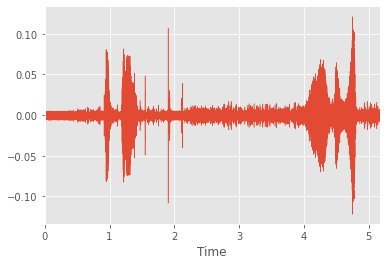

In [0]:
librosa.display.waveplot(data, sr=sr)

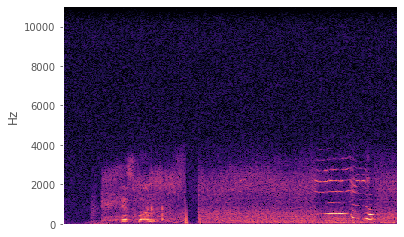

In [0]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')  # Compute linear-based spectrogram

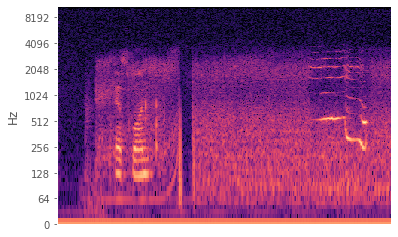

In [0]:
librosa.display.specshow(D, y_axis='log') # Compute log-based spectrogram

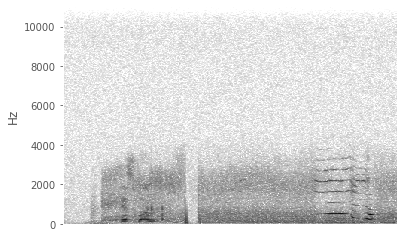

In [0]:
librosa.display.specshow(D, cmap='gray_r', y_axis='linear') # Compute linear-based spectrogram with greyscale colormap

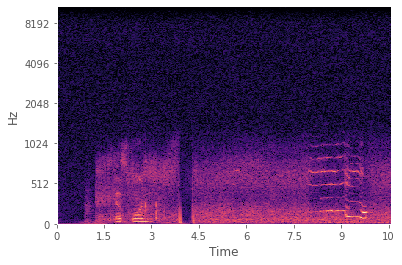

In [0]:
# Spectrogram with STFT
D = np.abs(librosa.stft(data, n_fft=2048, win_length=2000, hop_length=500))
librosa.display.specshow(librosa.amplitude_to_db(D, ref = np.max),y_axis='mel', x_axis='time')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal r

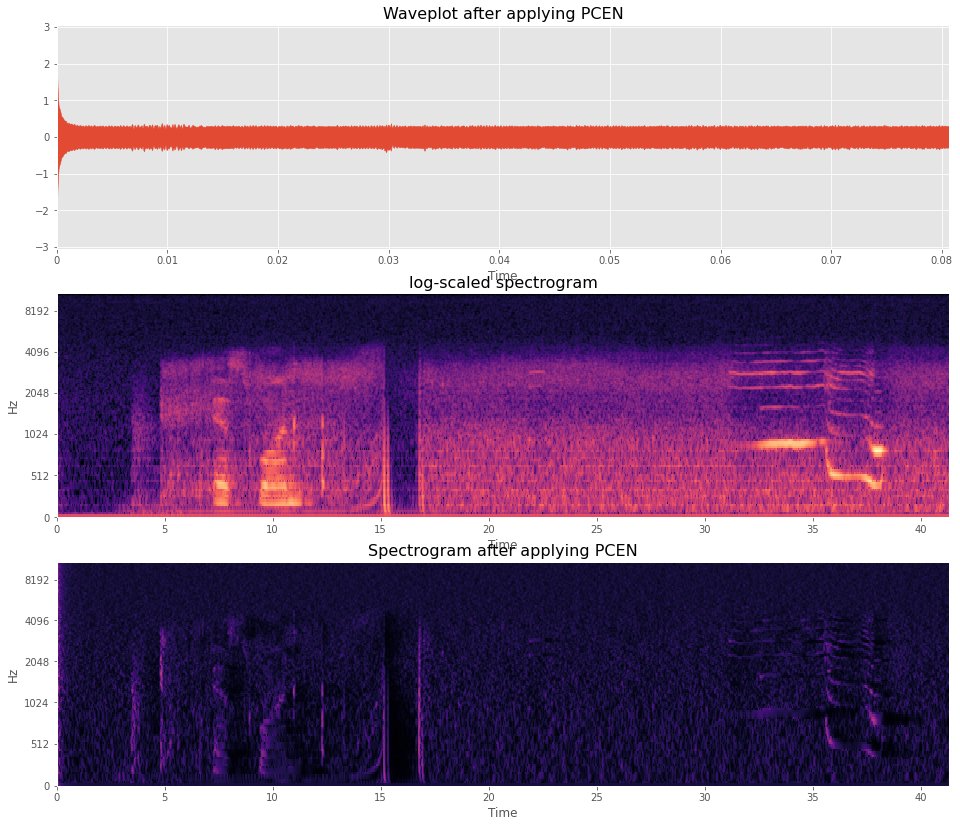

In [0]:
# Applying PCEN

S = librosa.feature.melspectrogram(data, sr=sr, power=1, n_fft=1024, hop_length=128) # Compute mel-scaled spectrogram
log_S = librosa.amplitude_to_db(S, ref=np.max) #Convert an amplitude spectrogram to dB-scaled spectrogram
pcen_S = librosa.core.pcen(S) #Compute Per-Channel Energy Normalization
plt.figure(figsize=(16, 14))
plt.subplot(3,1,1)
plt.title('Waveplot after applying PCEN', fontsize=16)
librosa.display.waveplot(pcen_S)
plt.subplot(3,1,2)
plt.title('log-scaled spectrogram', fontsize=16)
librosa.display.specshow(log_S, x_axis='time', y_axis='mel')
plt.subplot(3,1,3)
plt.title('Spectrogram after applying PCEN', fontsize=16)
librosa.display.specshow(pcen_S, x_axis='time', y_axis='mel')

In [0]:
def padding(data, input_length):
    '''Padding of samples to make them of same length'''
    if len(data) > input_length:
        max_offset = len(data) - input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length + offset)]
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
    return data

In [0]:
def audio_norm(data):
    '''Normalization of audio'''
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data - min_data) / (max_data - min_data + 1e-6)
    return data - 0.5


def mfcc(data, sampling_rate, n_mfcc):
    '''Compute mel-scaled feature using librosa'''
    data = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
    # data = np.expand_dims(data, axis=-1)
    return data

In [0]:
def apply_per_channel_energy_norm(data, sampling_rate):
    '''Compute Per-Channel Energy Normalization (PCEN)'''
    S = librosa.feature.melspectrogram(
        data, sr=sampling_rate, power=1)  # Compute mel-scaled spectrogram
    # Convert an amplitude spectrogram to dB-scaled spectrogram
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    pcen_S = librosa.core.pcen(S)
    return pcen_S

In [0]:
def wavelet_denoising(data):
    '''
    Wavelet Denoising using scikit-image
    NOTE: Wavelet denoising is an effective method for SNR improvement in environments with
              wide range of noise types competing for the same subspace.
    '''
    sigma_est = estimate_sigma(data, multichannel=True, average_sigmas=True)
    im_bayes = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='BayesShrink',
                               mode='soft')
    im_visushrink = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                    mode='soft')

    # VisuShrink is designed to eliminate noise with high probability, but this
    # results in a visually over-smooth appearance. Here, we specify a reduction
    # in the threshold by factors of 2 and 4.
    im_visushrink2 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 2)
    im_visushrink4 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 4)
    return im_bayes

In [0]:
def set_rate(audio, rate):
    '''Set sampling rate'''
    return audio.set_frame_rate(rate)


def make_chunks(filename, chunk_size, sampling_rate, target_location):
    '''Divide the audio file into chunk_size samples'''
    f = AudioSegment.from_wav(filename)

    if f.frame_rate != sampling_rate:
        f = set_rate(f, sampling_rate)

    j = 0

    if not os.path.exists(target_location):
        os.makedirs(target_location)

    os.chdir(target_location)

    f_name = os.path.basename(filename)

    while len(f[:]) >= chunk_size * 1000:
        chunk = f[:chunk_size * 1000]
        chunk.export(f_name[:-4] + "_{:04d}.wav".format(j), format="wav")
        logger.info("Padded file stored as " + f_name[:-4] + "_{:04d}.wav".format(j))
        f = f[chunk_size * 1000:]
        j += 1

    if 0 < len(f[:]) and len(f[:]) < chunk_size * 1000:
        silent = AudioSegment.silent(duration=chunk_size * 1000)
        paddedData = silent.overlay(f, position=0, times=1)
        paddedData.export(f_name[:-4] + "_{:04d}.wav".format(j), format="wav")
        logger.info("Padded file stored as " + f_name[:-4] + "_{:04d}.wav".format(j))

In [0]:
def plot_and_save(denoised_data, f_name):

    fig, ax = plt.subplots()

    i = 0
    # Add this line to show plots else ignore warnings
    # plt.ion()

    ax.imshow(denoised_data)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.set_size_inches(10, 10)
    fig.savefig(
        f"{f_name[:-4]}" + "_{:04d}.png".format(i),
        dpi=80,
        bbox_inches="tight",
        quality=95,
        pad_inches=0.0)

    fig.canvas.draw()
    fig.canvas.flush_events()
    i += 1


In [0]:
def standardize_and_plot(sampling_rate, file_path_image):
    logger.info(f"All files will be resampled to {sampling_rate}Hz")

    output_image_folder = "PreProcessed_image/"

    for dirs, subdirs, files in os.walk(file_path_image):
        for i, file in enumerate(files):
            if file.endswith(('.wav', '.WAV')):
                logger.info(f"Pre-Processing file: {file}")
                data, sr = librosa.core.load(
                    os.path.join(dirs, file), sr=sampling_rate, res_type='kaiser_fast')
                target_path = os.path.join(output_image_folder, dirs)

                # There is no need to apply padding since all samples are of same length
                # padded_data = padding(data, input_length)

                # TODO: mismatch of shape
                # if use_mfcc:
                #     mfcc_data = mfcc(padded_data, sampling_rate, n_mfcc)
                # else:
                #     mfcc_data = preprocessing_fn(padded_data)[:, np.newaxis]

                pcen_S = apply_per_channel_energy_norm(data, sr)

                denoised_data = wavelet_denoising(pcen_S)

                work_dir = os.getcwd()

                if not os.path.exists(target_path):
                    os.makedirs(target_path)

                os.chdir(target_path)

                f_name = os.path.basename(file)

                plot_and_save(denoised_data, f_name)

                os.chdir(work_dir)

In [0]:
chunkSize = 4
sampling_rate = 44100
file_path_audio = 'Field Recordings NGOS'
# audio_duration = 
use_mfcc = False
n_mfcc = 20

no_of_files = len(os.listdir('.'))

output_audio_folder = "PreProcessed_audio/"

# Traverse all files inside each sub-folder and make chunks of audio file
for dirs, subdirs, files in os.walk(file_path_audio):
    for file in files:
        if file.endswith(('.wav', '.WAV')):
            logger.info(f"Making chunks of size {chunkSize}s of file: {file}")

            input_file = os.path.join(dirs, file)

            work_dir = os.getcwd()

            output_path = os.path.join(output_audio_folder, dirs)

            '''
            CouldntDecodeError: Decoding failed. ffmpeg returned error
            code: 1 in file ._20180605_0645_AD8.wav 2018, so catching exception
            '''
            try:
                make_chunks(
                    input_file,
                    chunkSize,
                    sampling_rate,
                    output_path)
            except Exception as e:
                logger.error(f"Exception: {e}", exc_info=True)
                pass

            os.chdir(work_dir)

In [0]:
file_path_image = os.path.join(output_audio_folder, file_path_audio)

logger.info(f"Starting to load {no_of_files} data files in the directory")

standardize_and_plot(sampling_rate, file_path_image)


INFO:__main__:Starting to load 14 data files in the directory
INFO:__main__:All files will be resampled to 44100Hz
